# How would Height of the basketball player affect the velocity it takes to make a free throw?

In [22]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from IPython.display import Image

Fm = S (w × v)

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
rad = UNITS.radian

<Unit('radian')>

# Abstract:
The free-throw is one of the determining factors that separate good players from great players. In basketball, when a player is fouled, they get a chance to shoot 1 to 3 shots from 4.9 meters away from the basket depending on the place and the manner in which they were fouled. We created a model for determining the minimum initial velocity it takes for an NBA player to make a free-throw. Taking into factors of gravity, drag, and the Magnus force, we were able to calculate the minimum initial velocity for players ranging from heights of 1.6 meters to 2.3 meters.


# Model
For our model, we made the following assumptions for our model of the free throw.

    According to Creighton University, the optimal angle to shoot a basketball is 52 degrees.
    The only forces acting on the basketball is the drag, Magnus force, and gravity
    The horizontal distance from the basket to the free-throw line is 4.9 meters
    The vertical distance from the basket is 3.05 meters
    The range for the basketball to fall in the basketball is plus/minus 0.115 meter horizontally

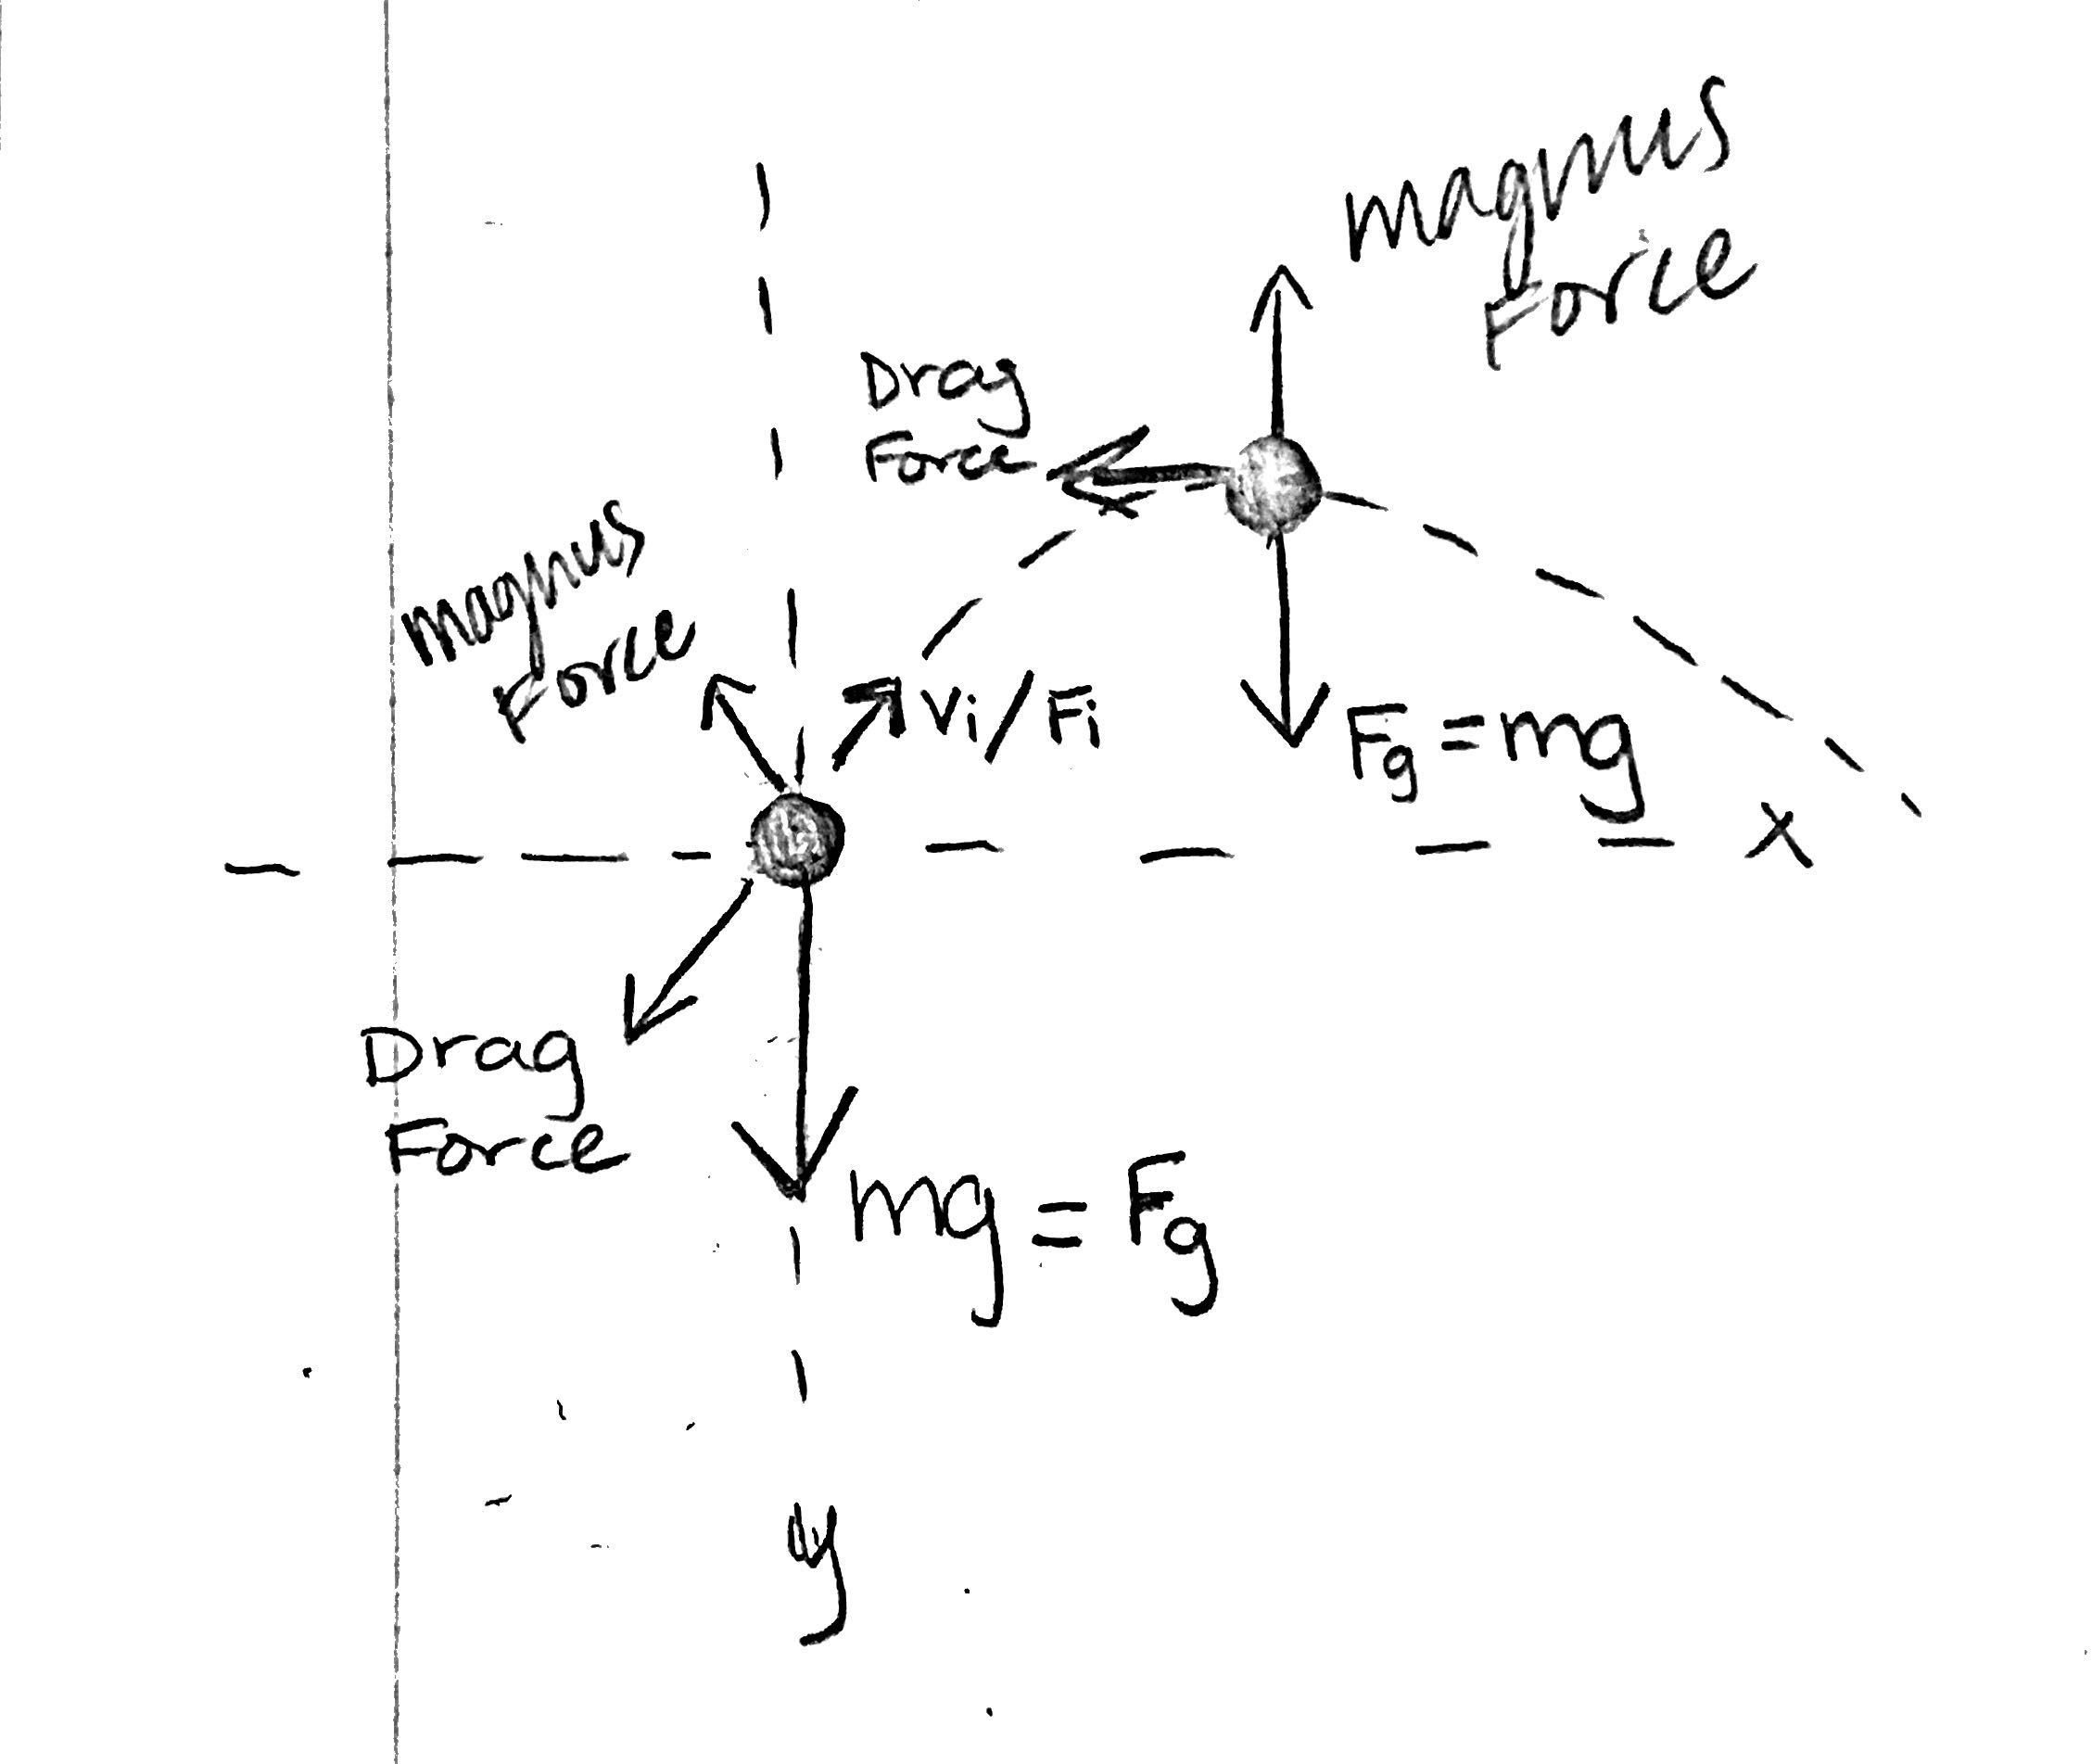

In [24]:
Image("Drawing for a friend-p1.jpg")
#Model Schematic
#Sorry it's huge. I don't know how to fix it!

In [3]:

params = Params(x = 0 * m,                   # x coordinate of the basketball
                y = 0 * m,                   # y coordinate of the basketball
                omega = 6 * np.pi * rad / s ** 2,    # angular velocity
                rho = 1.2 * kg / m ** 3,     # mass density of the fluid
                C_d = 0.54,                  # drag coefficient of a basketball
                x_dist = 4.9 * m,            # horizontal distance of player to net
                y_dist = 3.05 * m,           # distance of the rim from ground
                v = 0 * m / s,               # velocity of the basketball
                S = 0.47,                    # air resistance coefficient of spheres
                g = 9.8 * m/s**2,            # gravity
                angle = 52 * degree,         # launch angle of the basketball
                mass = 0.625 * kg,           # mass of the basketball
                diameter = 0.23 * m,         # diameter of the basketball
                radius = 0.115 * m,          # radius of the basketball
                t_end = 10 * s)

,values
x,0 meter
y,0 meter
omega,18.84955592153876 radian / second ** 2
rho,1.2 kilogram / meter ** 3
C_d,0.54
x_dist,4.9 meter
y_dist,3.05 meter
v,0.0 meter / second
S,0.47
g,9.8 meter / second ** 2


In [4]:
def make_system(params, v_0, height):
    """Make a system object.
    
    params: 
    
    returns: System object
    """
    unpack(params)
     # convert angle to degrees
    theta = np.deg2rad(angle)
    
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, v_0)
  
    init = State(x = x, y = height, vx = vx, vy = vy)

    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area = area)

In [5]:
system = make_system(params, 0 * m / s, 1.8 * m)

,values
x,0 meter
y,0 meter
omega,18.84955592153876 radian / second ** 2
rho,1.2 kilogram / meter ** 3
C_d,0.54
x_dist,4.9 meter
y_dist,3.05 meter
v,0.0 meter / second
S,0.47
g,9.8 meter / second ** 2


In [6]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    #direction is that opposite of velocity 
    #(reflected by negative sign in magnitude)
    f_drag = mag * direction
    return f_drag

In [7]:
def magnus_force(V,system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    magnitude = 16/3 * np.pi**2 * radius**3 * rho
    f_magnus = magnitude * np.cross(Vector(0,omega).hat(),V.hat()) 
    #direction is the cross product of the direction of omega and velocity
    return f_magnus

In [8]:
def slope_func1(state, t, system): #assumes no drag or magnus
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)
    a_grav = Vector(0, -g)
    
    a = a_grav 
   
    return vx, vy, a.x, a.y

In [9]:
def slope_func2(state, t, system): #assumes no magnus
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag 
   
    
    return vx, vy, a.x, a.y

In [10]:
def slope_func(state, t, system): #includes gravity, drag, and magnus
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    a_magnus = magnus_force(V,system)/ mass
    
    a = a_grav + a_drag - a_magnus
    #magnus force has an acceleration in direction opposite of gravitation and drag
    
    return vx, vy, a.x, a.y

In [11]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return x - 4.9 
    #stops when the x position is that of the basket

In [12]:
def height_func(v_0, height): #height_func incorporating all 3 forces
    system = make_system(params, v_0 = v_0, height = height)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    return Vector(get_last_value(results.x) * m, get_last_value(results.y) * m)

In [13]:
def height_func1(v_0, height): #no drag or magnus
    system = make_system(params, v_0 = v_0, height = height)
    results, details = run_ode_solver(system, slope_func1, events=event_func)
    return Vector(get_last_value(results.x) * m, get_last_value(results.y) * m)

In [14]:
def height_func2(v_0, height): #no magnus
    system = make_system(params, v_0 = v_0, height = height)
    results, details = run_ode_solver(system, slope_func2, events=event_func)
    return Vector(get_last_value(results.x) * m, get_last_value(results.y) * m)

In [15]:
height_func(20 * m /s, 1.8*  m) #tests our code

<Quantity([4.9       7.2039358], 'meter')>

In [16]:
def graph(): #incorporates all 3 forces
    velocities = linspace(6,12,400)
    #creates an array of velocities that is within the expected range
    heights = linspace(1.6, 2.3, 25)
    #creates an array of heights from shortest to tallest player
    sweep_h = SweepSeries()

    print(heights)
    # runs through the height array and the velocity array 
    # to find minimum initially velocity required to make a basket
    for h in heights: 
        sweep_v = SweepSeries()
        for vel in velocities:
            vector = height_func(vel * m / s, h * m)
            if(vector.y.mag < 3.165 * m and vector.y.mag > 2.935 * m):
                print(h, vel, vector)
                sweep_v[vel] = vector
                break
        sweep_h[h] = sweep_v.index[0]
    return sweep_h

In [17]:
def graph1(): #no drag or magnus
    velocities = linspace(6,12,400)
    #creates an array of velocities that is within the expected range
    heights = linspace(1.6, 2.3, 25)
    #creates an array of heights from shortest to tallest player
    sweep_h = SweepSeries()

    print(heights)
    # runs through the height array and the velocity array 
    # to find minimum initially velocity required to make a basket
    for h in heights: 
        sweep_v = SweepSeries()
        for vel in velocities:
            vector = height_func1(vel * m / s, h * m)
            if(vector.y.mag < 3.165 * m and vector.y.mag > 2.935 * m):
                print(h, vel, vector)
                sweep_v[vel] = vector
                break
        sweep_h[h] = sweep_v.index[0]
    return sweep_h

In [18]:
def graph2(): #no magnus
    velocities = linspace(6,12,400)
    #creates an array of velocities that is within the expected range
    heights = linspace(1.6, 2.3, 25)
    #creates an array of heights from shortest to tallest player
    sweep_h = SweepSeries()

    print(heights)
    # runs through the height array and the velocity array 
    # to find minimum initially velocity required to make a basket
    for h in heights: 
        sweep_v = SweepSeries()
        for vel in velocities:
            vector = height_func2(vel * m / s, h * m)
            if(vector.y.mag < 3.165 * m and vector.y.mag > 2.935 * m):
                print(h, vel, vector)
                sweep_v[vel] = vector
                break
        sweep_h[h] = sweep_v.index[0]
    return sweep_h

[1.6        1.62916667 1.65833333 1.6875     1.71666667 1.74583333
 1.775      1.80416667 1.83333333 1.8625     1.89166667 1.92083333
 1.95       1.97916667 2.00833333 2.0375     2.06666667 2.09583333
 2.125      2.15416667 2.18333333 2.2125     2.24166667 2.27083333
 2.3       ]
1.6 8.225563909774436 [4.9        2.94278213] meter
1.6291666666666667 8.195488721804512 [4.9        2.93711559] meter
1.6583333333333334 8.180451127819548 [4.9        2.94872365] meter
1.6875 8.150375939849624 [4.9        2.94249537] meter
1.7166666666666668 8.1203007518797 [4.9        2.93588604] meter
1.7458333333333333 8.105263157894736 [4.9        2.94701707] meter
1.775 8.075187969924812 [4.9        2.93982564] meter
1.8041666666666667 8.06015037593985 [4.9        2.95066218] meter
1.8333333333333333 8.030075187969924 [4.9        2.94287601] meter
1.8625 8.015037593984962 [4.9        2.95341165] meter
1.8916666666666666 7.984962406015038 [4.9        2.94501777] meter
1.9208333333333334 7.954887218045113 

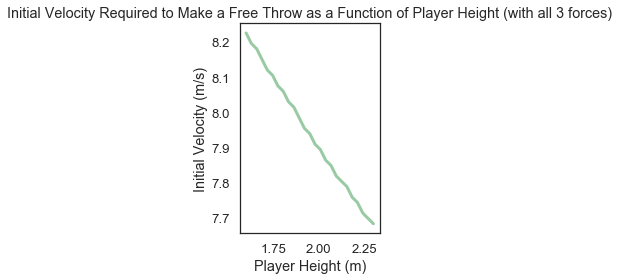

In [19]:
plot(graph(), color='C2') #graph with all 3 forces included
decorate(xlabel='Player Height (m)',
         ylabel='Initial Velocity (m/s)',
         title='Initial Velocity Required to Make a Free Throw as a Function of Player Height (with all 3 forces)',
         legend=False)

[1.6        1.62916667 1.65833333 1.6875     1.71666667 1.74583333
 1.775      1.80416667 1.83333333 1.8625     1.89166667 1.92083333
 1.95       1.97916667 2.00833333 2.0375     2.06666667 2.09583333
 2.125      2.15416667 2.18333333 2.2125     2.24166667 2.27083333
 2.3       ]
1.6 7.93984962406015 [4.9       2.9481484] meter
1.6291666666666667 7.909774436090226 [4.9        2.93980232] meter
1.6583333333333334 7.894736842105263 [4.9        2.95005165] meter
1.6875 7.864661654135338 [4.9        2.94105757] meter
1.7166666666666668 7.849624060150376 [4.9        2.95097916] meter
1.7458333333333333 7.819548872180452 [4.9        2.94132207] meter
1.775 7.804511278195489 [4.9        2.95090833] meter
1.8041666666666667 7.774436090225564 [4.9        2.94057277] meter
1.8333333333333333 7.7593984962406015 [4.9        2.94981586] meter
1.8625 7.7293233082706765 [4.9        2.93878594] meter
1.8916666666666666 7.714285714285714 [4.9        2.94767779] meter
1.9208333333333334 7.68421052631578

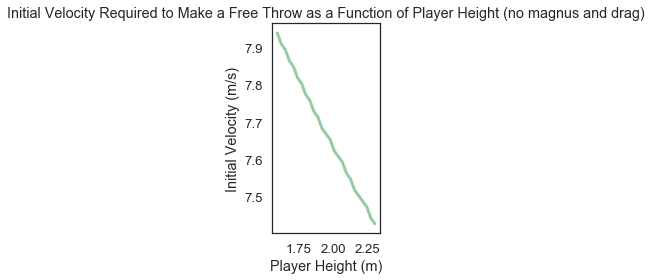

In [20]:
plot(graph1(), color='C2') #graph without drag and magnus
decorate(xlabel='Player Height (m)',
         ylabel='Initial Velocity (m/s)',
         title='Initial Velocity Required to Make a Free Throw as a Function of Player Height (no magnus and drag)',
         legend=False)

[1.6        1.62916667 1.65833333 1.6875     1.71666667 1.74583333
 1.775      1.80416667 1.83333333 1.8625     1.89166667 1.92083333
 1.95       1.97916667 2.00833333 2.0375     2.06666667 2.09583333
 2.125      2.15416667 2.18333333 2.2125     2.24166667 2.27083333
 2.3       ]
1.6 8.31578947368421 [4.9        2.93546422] meter
1.6291666666666667 8.300751879699249 [4.9      2.946937] meter
1.6583333333333334 8.270676691729323 [4.9        2.94043122] meter
1.6875 8.25563909774436 [4.9        2.95161261] meter
1.7166666666666668 8.225563909774436 [4.9        2.94451816] meter
1.7458333333333333 8.195488721804512 [4.9       2.9370241] meter
1.775 8.180451127819548 [4.9        2.94770538] meter
1.8041666666666667 8.150375939849624 [4.9        2.93960052] meter
1.8333333333333333 8.13533834586466 [4.9        2.94997269] meter
1.8625 8.105263157894736 [4.9        2.94124325] meter
1.8916666666666666 8.090225563909774 [4.9        2.95129934] meter
1.9208333333333334 8.06015037593985 [4.9   

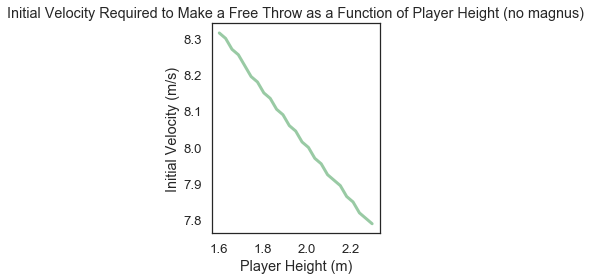

In [21]:
plot(graph2(), color='C2') #no magnus
decorate(xlabel='Player Height (m)',
         ylabel='Initial Velocity (m/s)',
         title='Initial Velocity Required to Make a Free Throw as a Function of Player Height (no magnus)',
         legend=False)

# Results:
From looking at the graphs, it can be seen that the graph without drag and magnus force requires the lowest initial velocity. The graph where magnus force and drag force are incorporated requires a slightly lower initial velocity than that with only the drag force. All three graphs show a negative correlation with height -- as player height increases, minimum initial velocity decreases. All three graphs also display relatively linear relationships.


# Interpretation:

The results are as expected but also, they give further insight into how each force affects the motion. As expected, increasing player height decreases the initial velocity required to make a basket -- thus revealing one of the reasons why taller basketball players are preferred. In addition to this, however, the graphs displayed each force’s impact on minimum initial velocity. Seeing that the graph without drag and magnus force has significantly lower minimum initial velocities that the graph with drag force shows that drag force has a large impact on the motion and that ignoring drag force is a major assumption that can detract from getting logical results over time. Magnus force, on the other hand, does decrease the minimum initial velocity required, but ignoring it would not make a significant impact in this scenario as the required velocity is only slightly higher when overlooking the effects of the magnus force. In addition to these applications, another takeaway from our model was confirming that there is always an approximately linear relationship between the minimum initial velocity and player heights in all three scenarios. This shows that the acceleration is approximately constant, as expected. 